In [4]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display
from scipy.stats import kurtosis, skew
from scipy import stats
import pywt
import scipy.stats
import re
import datetime as dt
from collections import defaultdict, Counter
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("whitegrid")
from scipy import signal
import itertools
import glob
import random
np. set_printoptions(threshold=np. inf)
from sklearn import preprocessing


In [2]:
mat=sio.loadmat('./Patient_1_interictal_segment_0001.mat')

In [3]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'preictal_segment_1'])

In [4]:
#length of series of electrode measurements corresponding to electrode 1
#length in seconds * sampling rate should equal this number
len(mat['preictal_segment_1'][0][0][0][1])

239766

In [5]:
#The length (in seconds) of the clip
mat['preictal_segment_1'][0][0][1][0]

array([600], dtype=uint16)

In [6]:
#The sampling rate (# of samples per second) in Hz
mat['preictal_segment_1'][0][0][2][0]

array([399.6097561])

In [7]:
#The name of the 1st electrode.
mat['preictal_segment_1'][0][0][3][0][14]

array(['NVC0905_22_004_Ecog_c016'], dtype='<U24')

In [8]:
#The name of the 2nd electrode.
mat['preictal_segment_1'][0][0][3][0][1]

array(['NVC0905_22_004_Ecog_c002'], dtype='<U24')

In [9]:
#The index of the clip's location within the hour (e.g. 4 = from minutes 40-50)
mat['preictal_segment_1'][0][0][4][0]

array([1], dtype=uint8)

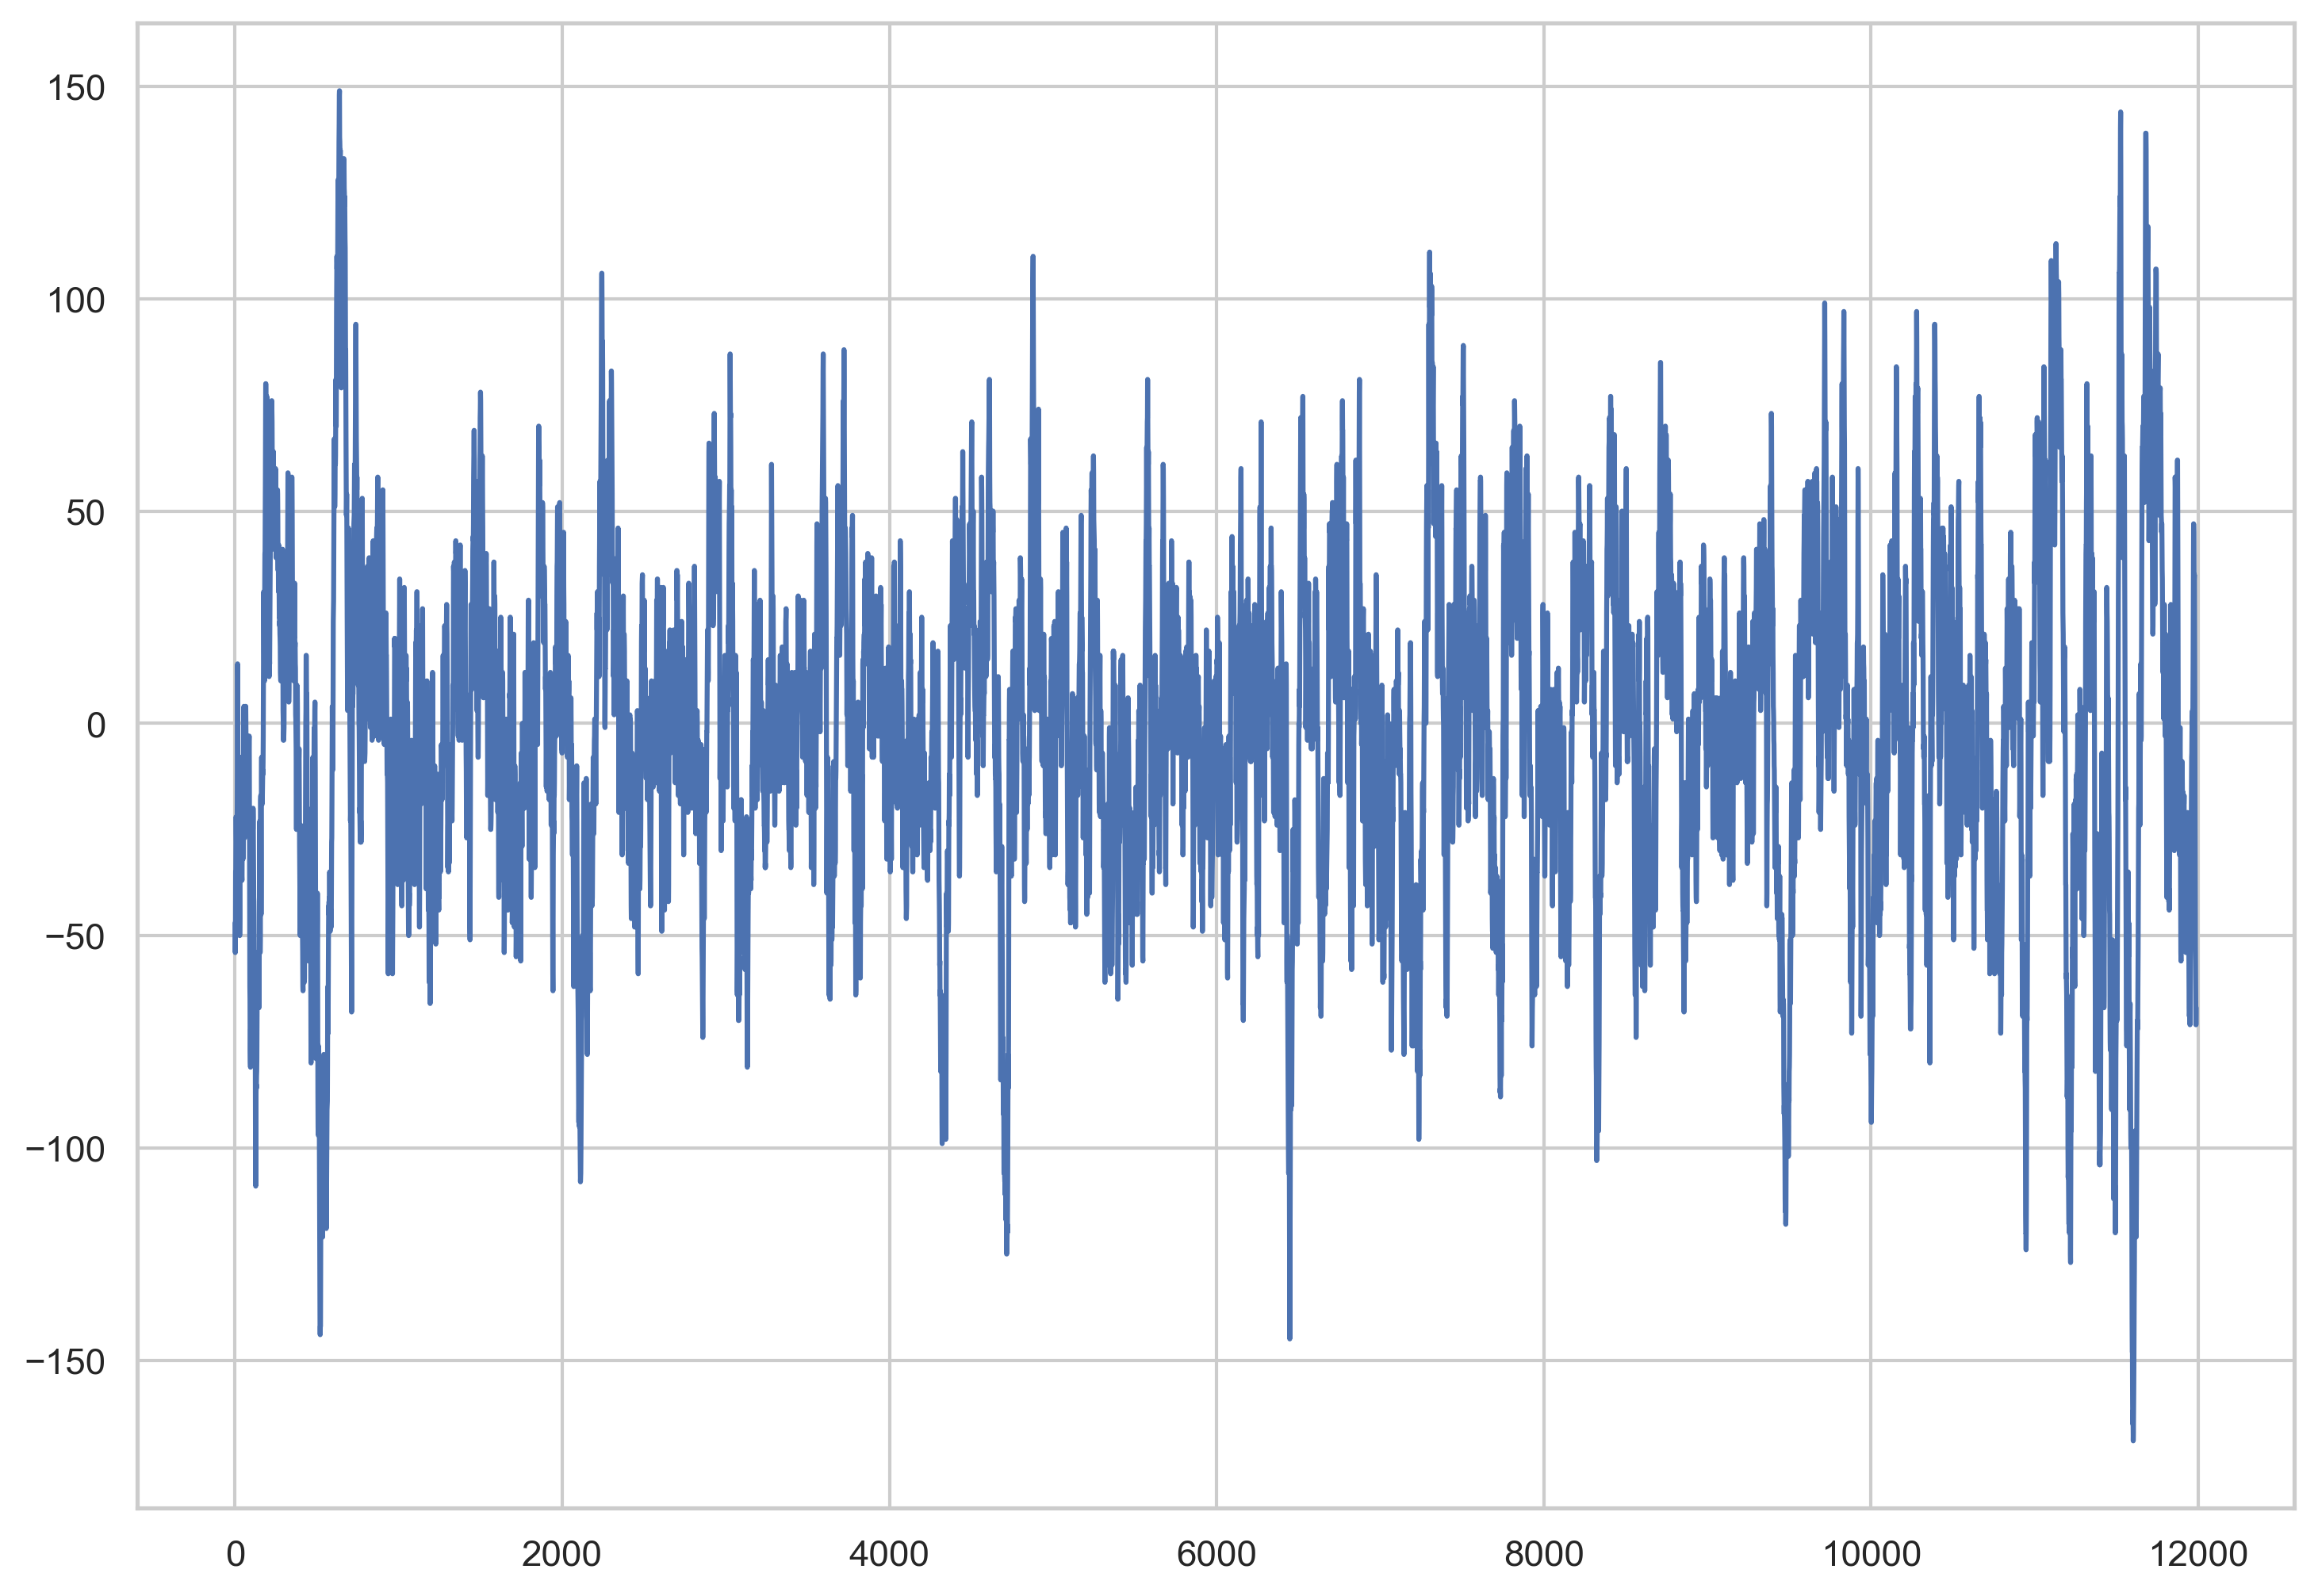

In [11]:
upper_limit = 11989+11989
data = mat['preictal_segment_1'][0][0][0][14][11989:upper_limit]
plt.plot(data)

In [71]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_data(filename):
   
    signal_df = pd.DataFrame()
    
    
    


    #get patient name 
    pattern = '^([^_]*_){2}'
    splice = (filename.rsplit('/', 1)[-1])
    patient = (re.match(pattern, splice)).group(0)

    #get segment type
    pattern = '^([^_]*_){3}'
    splice = (filename.rsplit('/', 1)[-1])
    segment = ((re.match(pattern, splice)).group(1)).replace("_", "")

    #get file number
    file_number = (filename.split("."))[1][-4:].lstrip("0")

    #generate file name
    name = segment + "_segment_" + file_number

    #get recording number 
    recording = (filename.rsplit('/', 1)[-1])[-8:-4]

    if 'Patient_1' in patient:
        electrodes = 15
        dec_factor=13
    if 'Patient_2' in patient:
        electrodes = 24
        dec_factor=13
    if 'Dog_5' in patient:
        electrodes = 15
        dec_factor=1
    elif 'Dog' in patient:
        electrodes = 16
        dec_factor=1

    #load data using loadmat
    eeg_data = sio.loadmat(filename)

    #create a dictionary to hold the data
    dict_eeg_data = defaultdict(list)

    #create a range from the number of electrodes to access files
    for i in list(range(electrodes)):
        
    # Sample rate and desired cutoff frequencies (in Hz).
        fs = 173
        lowcut = 3
        highcut = 8

        #access each array by electrode index number

        eeg_signals = signal.resample(((eeg_data[name][0][0][0][i])),153600)


        #access each electrode name by electrode index number 

        eeg_labels_ = eeg_data[name][0][0][3][0][i]


        for ii,label in enumerate(eeg_labels_):
            #append data from eeg_data to dictionary using electrode name as label
                dict_eeg_data[label].append(eeg_signals[ii:])


    #create df from dict, transpose, and create electrode name as column      
    df =  pd.DataFrame(dict_eeg_data).T.rename_axis('Electrode').reset_index(drop=False).rename(columns = {0: "Array"})

    #label data with segment type 
    df['y'] = segment

    #create list of cols 
    cols = df.columns.tolist()

   #rename segments 
    df['Recording'] = str(patient)  + str(recording) + "_" + df['Electrode'].str[-4:] + "_" + segment


    #shift last column to first 
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]

    #drop unwanted columns
    col = ['Electrode']
    df = df.drop(col, axis=1)




    signal_df = signal_df.append(df, ignore_index=True)

        
    
    return  signal_df


In [72]:
filename = './Patient_1_interictal_segment_0001.mat'
data = get_data(filename)

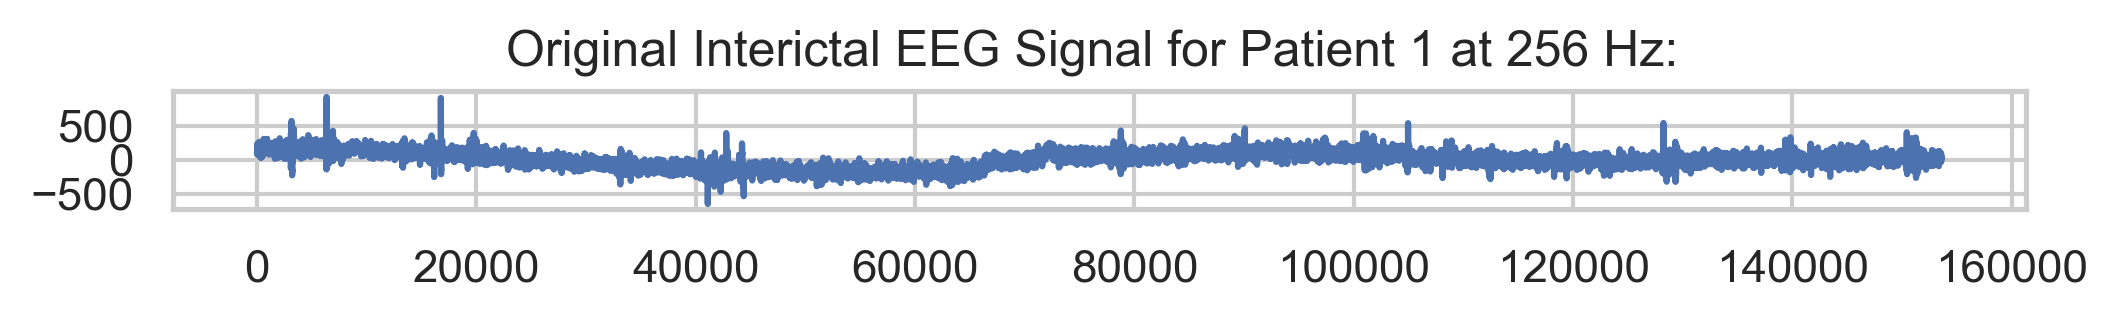

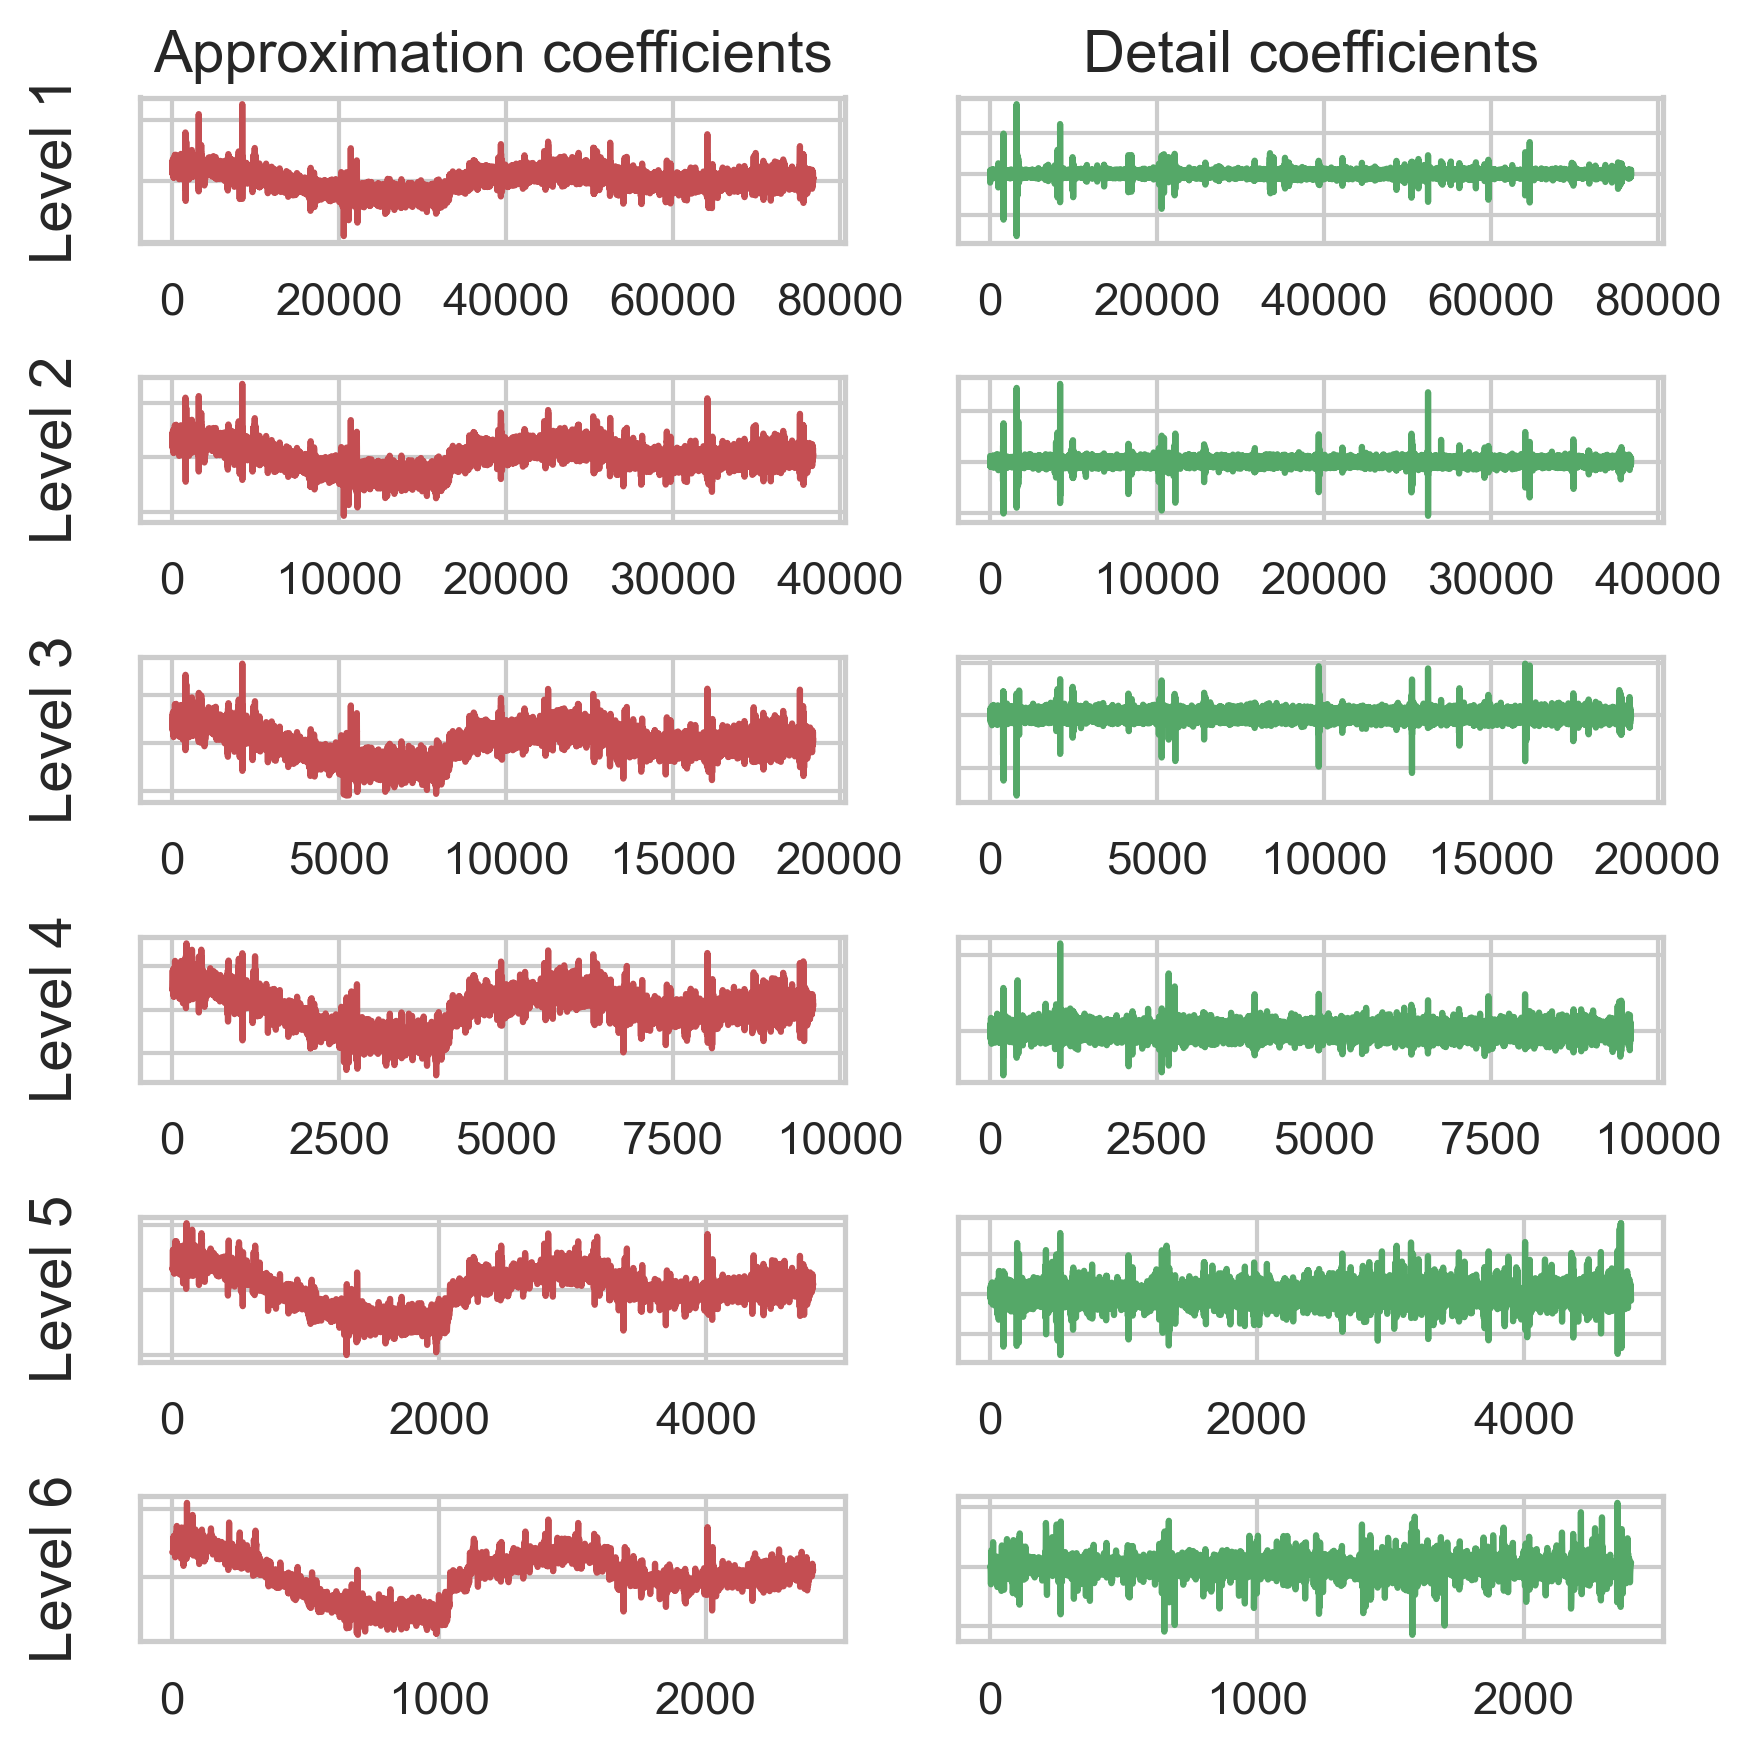

In [74]:


#graph breakdown of signal using DWT
 
x = np.linspace(0, 1, num=2048)
data = data.iloc[0,1]
    
fig, ax = plt.subplots(figsize=(7,1))
ax.set_title("Original Interictal EEG Signal for Patient 1 at 256 Hz: ")
ax.plot(data)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("interictal_title.png")
plt.show()



waveletname = 'db3'
 
fig, axarr = plt.subplots(nrows=6, ncols=2, figsize=(6,6))
for ii in range(6):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    
plt.tight_layout()
plt.show()
fig.savefig("interictal.png")



In [75]:
filename = './Patient_1_preictal_segment_0001.mat'
data2 = get_data(filename)

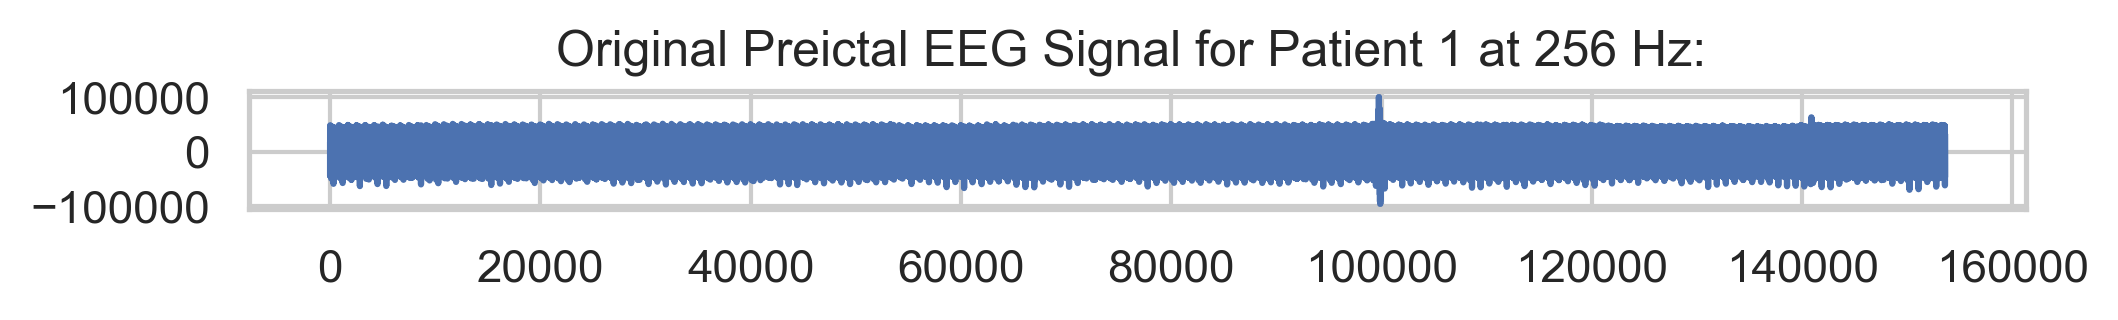

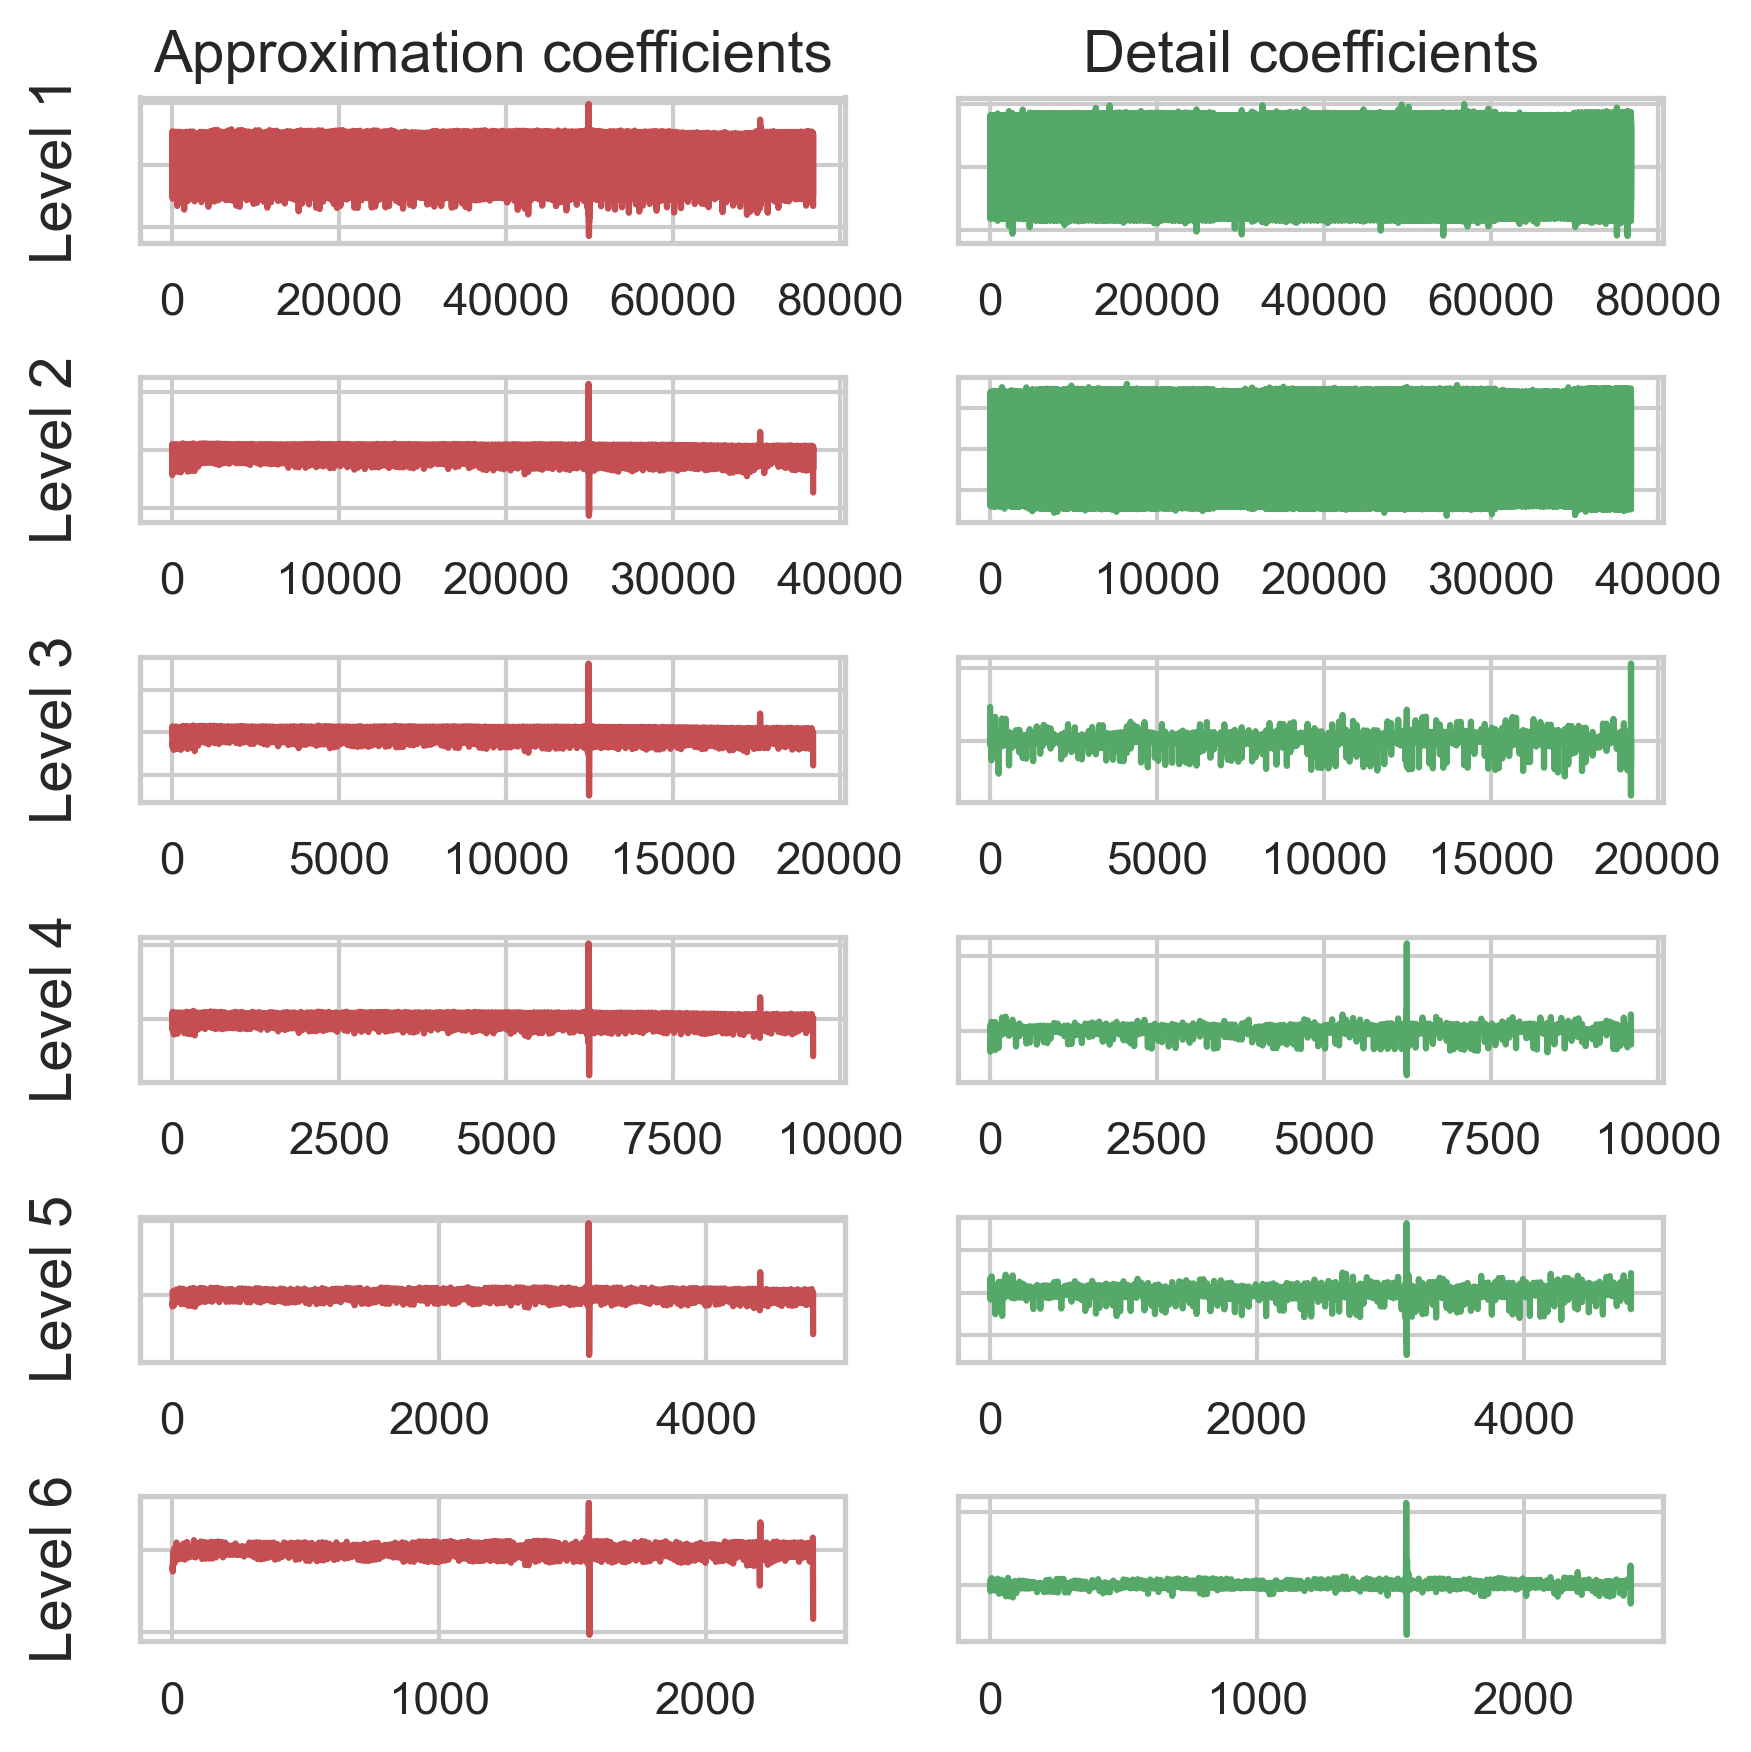

In [76]:

#graph breakdown of signal using DWT
 
x = np.linspace(0, 1, num=2048)
data = data2.iloc[0,1]
    
fig, ax = plt.subplots(figsize=(7,1))
ax.set_title("Original Preictal EEG Signal for Patient 1 at 256 Hz: ")
ax.plot(data)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("preictal_title.png")
plt.show()



waveletname = 'db3'
 
fig, axarr = plt.subplots(nrows=6, ncols=2, figsize=(6,6))
for ii in range(6):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    
plt.tight_layout()
fig.savefig("preictal.png")
plt.show()

